
# Project description

- Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
- We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.
- Build a model with the maximum possible F1 score. 
- To pass the project, you need an F1 score of at least 0.59. Check the F1 for the test set.
- Additionally, measure the AUC-ROC metric and compare it with the F1.

In [1]:
#Import all libraries
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns#visualization
sns.set(style="ticks", color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#define most used variables
F1_REQUIRED=0.59  #F1 = 2 * (precision * recall) / (precision + recall)
RANDOM_STATE=12345
target_names = ['Exited 0', 'Exited 1']   #Used in printing classification report


In [2]:
import sys
print (sys.version)

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]


# STEP 1 - DATA PREPROCESSING

- Download and prepare the data. 
- Explain the procedure.

Data description
The data can be found in /datasets/Churn.csv file. Download the dataset.
**Features**
- RowNumber — data string index
- CustomerId — unique customer identifier
- Surname — surname
- CreditScore — credit score
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — period of maturation for a customer’s fixed deposit (years)
- Balance — account balance
- NumOfProducts — number of banking products used by the customer
- HasCrCard — customer has a credit card
- IsActiveMember — customer’s activeness
- EstimatedSalary — estimated salary
- Target
- Exited — сustomer has left

In [3]:
#Import the file and create the dataset
path = '/datasets'
df = pd.read_csv(path+'/Churn.csv')

In [4]:
def display_information(df):
    print('Head:')
    print()
    display(df.head())
    print ('-'*100)
    print('Info:')
    print()
    display(df.info())
    print ('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print ('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    print ('-'*100)
    print('Shape:')
    print(df.shape)
    print ('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.'.format(df.duplicated().sum()) + "\033[0m")
    
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

def get_percent_of_na(df):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index,s.values):
        
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent,num,num_of_nulls))
        
    if count !=0:
        print('There are {} columns with NA!'.format(count))
    else:
        print()
        print('There are no columns with NA!')

In [5]:
display_information(df)

Head:



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

----------------------------------------------------------------------------------------------------
Describe:



,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


----------------------------------------------------------------------------------------------------


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457



Columns with nulls:


,Missing Values,Percent of Nulls
RowNumber,0,0.00
CustomerId,0,0.00
Surname,0,0.00
CreditScore,0,0.00
Geography,0,0.00
Gender,0,0.00
Age,0,0.00
Tenure,909,9.09
Balance,0,0.00
NumOfProducts,0,0.00


----------------------------------------------------------------------------------------------------
Shape:
(10000, 14)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.


# CONCLUSION:
I don't see any outliers. 
The only data I see problematic is if we have all zeroes in Balance, HasCrCard, NumOfProducts, IsActiveMember.

In [6]:
df_zerotest = df.query('Balance==0 & HasCrCard==0 & NumOfProducts==0')
df_zerotest.shape

(0, 14)

# CONCLUSION
Customers have atleast one of Balance, Credit Card or NumOfProducts. 

In [7]:
display(df.head(5),df.tail(5))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [8]:
#Droping 3 columns which will have no use in the Supervised Learning
df=df.drop(['CustomerId','RowNumber','Surname'],axis=1)

In [9]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

# CONCLUSION
- Dropped three columns: CustomerId, RowNumber, Surname. Not needed.
- Checked 'Tenure' column has Nan values.
- I need to identify if this column will have impact on the prediction of values.
- I will check which columns have Nan Values for Tenure to see if they can be replaced.

In [10]:
df1 = df[df.isna().any(axis=1)]
print(df1.shape)
display(df1.pivot_table(index=['Exited','Geography','CreditScore','Gender'],values='Balance',aggfunc=['mean','count']))

(909, 11)


mean   count
                                       Balance Balance
Exited Geography CreditScore Gender                   
0      France    413         Male         0.00       1
                 428         Female       0.00       1
                 435         Male         0.00       1
                 438         Female       0.00       1
                 444         Male         0.00       1
...                                        ...     ...
1      Spain     738         Male         0.00       1
                 785         Female  129855.72       1
                 790         Male    182364.53       1
                 828         Male    109876.82       1
                 850         Male    103007.47       2

[760 rows x 2 columns]

In [11]:
valueFrance = df[df['Geography']=='France']['Tenure'].median()
valueSpain =  df[df['Geography']=='Spain']['Tenure'].median()
print(valueFrance, valueSpain)

5.0 5.0


In [12]:
df['Tenure'].fillna(df['Tenure'].median(),inplace=True)
print(df['Tenure'].isnull().sum())

0


# CONCLUSION
- Replaced the null values in Tenure column with median value.
- Reason: Tenure has Nan values for the customers in countries: France, Spain.
- I calculated the median of Tenure for each of these countries, came out to 5
- Hence I replaced the Nan values with the median value which is 5.
- No more Nan values

# STEP-2: EXPLORATORY DATA ANALYSIS

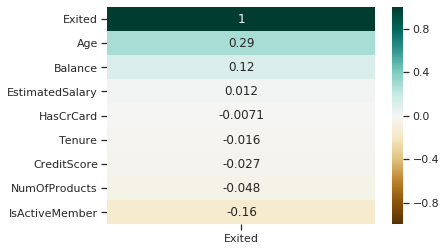

In [13]:
heatmap = sns.heatmap(df.corr()[['Exited']].sort_values(by='Exited', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

# CONCLUSION
- The heatmap depicts that Churn has positive correlation with Age, Balance and Estimated Salary. However, the correlation doesn't seem to be very strong.

- Churn (Exited) also has negative correlation with HasCreditCard, tenure, CreditScore,NumOfProducts, IsActiveMember.

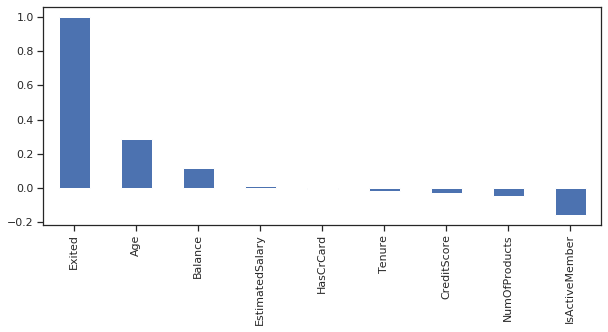

In [14]:
plt.figure(figsize=(10,4))
df.corr()['Exited'].sort_values(ascending = False).plot(kind='bar')

# CONCLUSION
The BAR Chart also displays that 

Age,Balance, IsActiveMember, NumOfProducts seem to have high correlation with the churn.

Text(0, 0.5, 'count')

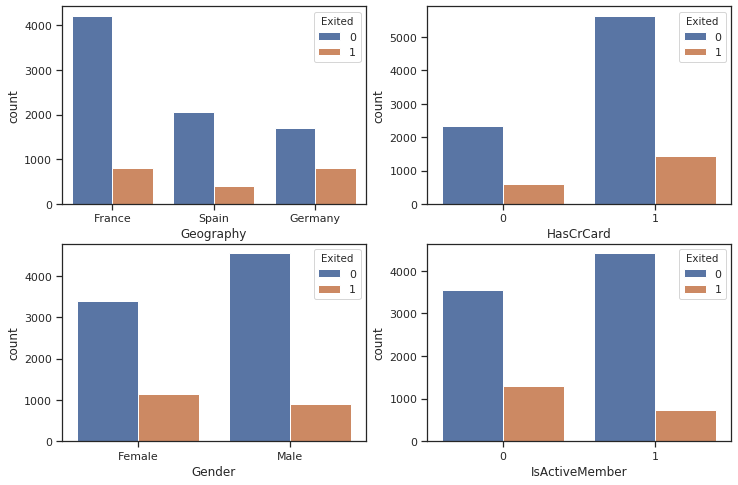

In [15]:
#Categorical attirbutes churn rate
fig, axis = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x= df.Geography, hue = 'Exited' ,data=df, ax =axis[0][0])
sns.countplot(x=df.Gender, hue = 'Exited' ,data=df, ax=axis[1][0])
sns.countplot(x=df.HasCrCard, hue = 'Exited' ,data=df, ax=axis[0][1])
sns.countplot(x=df.IsActiveMember, hue = 'Exited' ,data=df, ax=axis[1][1])
plt.ylabel('count')

# CONCLUSION
- Geography: France show a huge number of customers with low churn.

- CreditCard: %age of customers without credit card are churning more. There is a much bigger percentage of customers with credit card.

- Gender: Female customers are churning more than male. More data is needed to confirm these exploratory findings. There are more male customers.

- IsActiveMember: Inactive customers are churning more than active ones. There are more active members than inactive members.

# STEP-3: FEATURE ENGINEERING

- We have two categorical columns: Geography,Gender
- We should OHE the columns in the dataset.

In [16]:
#Define OHE columns for Supervised Learning
df_ohe=pd.get_dummies(df,drop_first=True)
print(df_ohe.shape)
display(df_ohe.head())

(10000, 12)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


# CONCLUSION
- Geography and Gender columns are OHEd.

# STEP-4: DEFINE TRAINING, VALIDATION AND TEST SETS

In [17]:
#Set the training, validation and test datasets (features and target)
target = df_ohe['Exited']
features = df_ohe.drop(['Exited'] , axis=1)


#FIRST SPLIT INTO TRAINING(60%) AND VALID_TEST (40%)
features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE)

#SPLIT VALID_TEST INTO VALIDATION and TEST (20% each)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_validtest, target_validtest, test_size=0.50, random_state=RANDOM_STATE)

totsize = len(df_ohe)
print('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
print('validation set: {0:.0%}'.format(len(features_valid)/totsize),features_valid.shape,', validation target :',target_valid.shape)
print('test set      : {0:.0%}'.format(len(features_test)/totsize),features_test.shape,', test target       :',target_test.shape)

training set  : 60% (6000, 11) , training target   : (6000,)
validation set: 20% (2000, 11) , validation target : (2000,)
test set      : 20% (2000, 11) , test target       : (2000,)


# CONCLUSION
Training set is 60%, Validation and Test sets are 20% each

# STANDARDIZE THE NUMERICAL FEATURES

In [18]:
#Standardize the numerical features.
#CreditScore	Age	Tenure	Balance	NumOfProducts	EstimatedSalary
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()

# < transform feature set >
scaler.fit(features_train[numeric])
features_train.loc[:,numeric] = scaler.transform(features_train[numeric])

# < transform validation set >
features_valid.loc[:,numeric] = scaler.transform(features_valid[numeric])

# < transform test set >
features_test.loc[:,numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

display('TRAINING SET',features_train.head(), 'VALIDATION SET',features_valid.head(),'TEST SET',features_test.head())

(6000, 11)
(2000, 11)
(2000, 11)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

'TRAINING SET'

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0


'VALIDATION SET'

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,-2.226392,-0.088482,-1.101690,-1.233163,0.830152,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.446272,-1.233163,-0.891560,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,-0.009707,0.722307,-0.891560,1,1,-1.369334,0,1,1
7775,-0.253277,0.101325,1.810266,-1.233163,0.830152,1,0,0.075086,0,1,1
8735,0.785204,-0.847708,1.810266,0.615625,-0.891560,0,1,-1.070919,0,0,1


'TEST SET'

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-1.101690,-1.233163,0.830152,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.737696,-1.233163,-0.891560,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.829679,0.438711,-0.891560,1,0,-1.367107,1,0,1
7365,-0.876366,-0.278288,1.810266,1.239884,-0.891560,1,1,-0.786517,0,1,0
7367,-0.481743,0.291132,1.810266,-1.233163,0.830152,1,0,1.358533,0,1,1


# CONCLUSION
All data sets are scaled correctly.



# BUILD A RESULT DATA FRAME

In [19]:
#Create a dataframe to store Model name, accuracy results - accuracy score, auc_roc, f1_score for valid, test, and if f1  and if the model met or exceeeded the required F1 score

column_names = ["method", "hyperparameters", "accuracy_score","auc_roc","f1_valid","f1_test",'f1_required','above_f1_threshold?']
df_results = pd.DataFrame(columns = column_names)

# STEP-5: TEST SUPERVISED LEARNING MODELS
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier

Try with these options of supervised learning: 
  - No Hyperparameters
  - balanced weights
  - Upsampled
  - Downsampled


In [20]:
#Function that accepts the model parameter and fits it to the sent data, then updates the results dataframe and returns the results dataframe
def supervisedModel(model,features_train, target_train,method,hyperparam):
      global df_results,predicted_test,target_test,predicted_valid, target_valid  #Using it in the function, global

      model.fit(features_train, target_train)
      predicted_valid = model.predict(features_valid)
      f1_valid = f1_score(target_valid,predicted_valid)
      
      predicted_test = model.predict(features_test)
      f1_test = f1_score(target_test,predicted_test)
      auc_roc = roc_auc_score(target_test, predicted_test)
      acc=accuracy_score(target_test,predicted_test)

      above_threshold = np.where( f1_test> F1_REQUIRED, True, False)
      resultRowStr= [method,hyperparam,acc,auc_roc,f1_valid,f1_test,F1_REQUIRED,above_threshold]
      rows = [pd.Series(resultRowStr, index=df_results.columns)]

      # append the rows
      df_results=df_results.append(rows,ignore_index=True).round(decimals=4)
      # check the rows 
      display(df_results)

# LogisticRegression (No Hyperparameter)

In [21]:
method="LogisticRegression"
hyperparam = "none"
model = LogisticRegression(solver='liblinear',random_state=RANDOM_STATE) 
supervisedModel(model,features_train, target_train,method, hyperparam)

,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.802,0.5932,0.2748,0.3311,0.59,False


# DecisionTreeClassifier with Hyperparameter: Depth

In [22]:
prevScore=0
foundDepth=0
for depth in range(1, 10, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    scoreR = f1_score(target_valid,predicted_valid)
    
    print("scoreR:",scoreR,"Depth:",depth)
    if (scoreR > prevScore):
        prevScore=scoreR
        foundDepth=depth
print('maxDepth',foundDepth)

method="DecisionTreeClassifier"
hyperparam = "depth: "+str(foundDepth)
model = DecisionTreeClassifier(max_depth=foundDepth,random_state=RANDOM_STATE)
supervisedModel(model,features_train, target_train,method, hyperparam)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


scoreR: 0.0 Depth: 1
scoreR: 0.4986301369863014 Depth: 2
scoreR: 0.3795620437956204 Depth: 3
scoreR: 0.48307692307692307 Depth: 4
scoreR: 0.5015772870662459 Depth: 5
scoreR: 0.5337423312883436 Depth: 6
scoreR: 0.4976816074188563 Depth: 7
scoreR: 0.48773006134969327 Depth: 8
scoreR: 0.5254470426409904 Depth: 9
maxDepth 6


,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.802,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.858,0.7078,0.5337,0.5697,0.59,False


# DecisionTreeClassifier with Hyperparameters: balanced weights,Depth

In [23]:
prevScore=0
foundDepth=0
for depth in range(1, 10, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE,class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    scoreR = f1_score(target_valid,predicted_valid)
    
    print("scoreR:",scoreR,"Depth:",depth)
    if (scoreR > prevScore):
        prevScore=scoreR
        foundDepth=depth
print('maxDepth',foundDepth)

method="DecisionTreeClassifier"
hyperparam = "Balanced, depth: "+str(foundDepth)
model = DecisionTreeClassifier(max_depth=foundDepth,class_weight='balanced',random_state=RANDOM_STATE)
supervisedModel(model,features_train, target_train,method, hyperparam)

scoreR: 0.48514851485148514 Depth: 1
scoreR: 0.5129682997118156 Depth: 2
scoreR: 0.5129682997118156 Depth: 3
scoreR: 0.5385239253852393 Depth: 4
scoreR: 0.5809128630705395 Depth: 5
scoreR: 0.5643835616438356 Depth: 6
scoreR: 0.5593869731800767 Depth: 7
scoreR: 0.5476635514018692 Depth: 8
scoreR: 0.5482625482625482 Depth: 9
maxDepth 5


,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True


# LogisticRegression with Hyperparameters: balanced weights

In [24]:
model = LogisticRegression(solver='liblinear',class_weight='balanced',random_state=RANDOM_STATE)

method="LogisticRegression"
hyperparam="Balanced"
supervisedModel(model,features_train, target_train,method, hyperparam)

,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False


# RandomForest with Hyperparameters: n_estimators, depth, balanced weights

In [25]:
prevScore=0.0
foundDepth=0
for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=RANDOM_STATE,  class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1_scor = f1_score(target_valid,predicted_valid)
    print("f1Score:",f1_scor,"Depth:",depth)
    if (f1_scor > prevScore):
        prevScore=f1_scor
        foundDepth=depth
print('maxDepth',foundDepth)

model = RandomForestClassifier(n_estimators=100, max_depth=foundDepth, random_state=RANDOM_STATE,  class_weight='balanced')
method="RandomForestClassifier"
hyperparam = "Balanced, depth: "+str(foundDepth)
supervisedModel(model,features_train, target_train,method, hyperparam)

f1Score: 0.5306122448979591 Depth: 1
f1Score: 0.558766859344894 Depth: 2
f1Score: 0.5532302092811647 Depth: 3
f1Score: 0.5685685685685686 Depth: 4
f1Score: 0.5897693079237714 Depth: 5
f1Score: 0.5916069600818832 Depth: 6
f1Score: 0.5851619644723092 Depth: 7
f1Score: 0.601536772777168 Depth: 8
f1Score: 0.6045454545454546 Depth: 9
f1Score: 0.5885167464114832 Depth: 10
f1Score: 0.5825977301387139 Depth: 11
f1Score: 0.5594594594594594 Depth: 12
f1Score: 0.5898491083676268 Depth: 13
f1Score: 0.5346820809248556 Depth: 14
f1Score: 0.542728635682159 Depth: 15
maxDepth 9


,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True


# CONFUSION MATRIX

In [26]:
#Confusion Matrix

confusion_matrix = confusion_matrix(target_test, predicted_test)
print(confusion_matrix)

[[1406  176]
 [ 144  274]]


- The Confusion Matrix displays that the DecisionTree classifier gave too many False Negatives.
- It also shows that the data has a lot of "True Negatives" which implies too many values are No, implying people didn't exit.
- Issue is class imbalance. Hence we need to fix the imbalance in the data to improve the model quality.

In [27]:
print(classification_report(target_test, predicted_test, target_names=target_names))

              precision    recall  f1-score   support

    Exited 0       0.91      0.89      0.90      1582
    Exited 1       0.61      0.66      0.63       418

    accuracy                           0.84      2000
   macro avg       0.76      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000



# CONCLUSION
- The Exited=0 values are predicted with f1_score of 79%, the Exited=1 values are predicted with f1_score of 48%
- We should test models with upsampling of Exited=1, and downsampling of Exited=0


# STEP-6: UpSampling, Downsampling


In [28]:
features_zeros = features_train[target_train==0]
features_ones = features_train[target_train==1]
target_zeros = target_train[target_train==0]
target_ones = target_train[target_train==1]
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4804, 11)
(1196, 11)
(4804,)
(1196,)


- Positive observations are less that negative observations.
- Less people have exited. (Exited=1 is less)
- We need to do upsampling


In [29]:
#Create Upsample
repeat = 2
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
print(features_upsampled.shape)
print(target_upsampled.shape)
features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)


(7196, 11)
(7196,)


In [30]:
#Test Upsample count
features_zeros = features_upsampled[target_train==0]
features_ones = features_upsampled[target_train==1]
target_zeros = target_upsampled[target_train==0]
target_ones = target_upsampled[target_train==1]
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4804, 11)
(2392, 11)
(4804,)
(2392,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
#TRYING DOWNSAMPLING, remove some (Exited=0)

print(features_train.shape)
fraction=0.8
features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
target_downsampled = pd.concat(
    [target_zeros.sample(frac=fraction,random_state=RANDOM_STATE)] + [target_ones])
features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)

print(features_downsampled.shape,target_downsampled.shape)

(6000, 11)
(6235, 11) (6235,)


In [32]:
#Test Downsample count
features_zeros = features_downsampled[target_train==0]
features_ones = features_downsampled[target_train==1]
target_zeros = target_downsampled[target_train==0]
target_ones = target_downsampled[target_train==1]
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(3843, 11)
(2392, 11)
(3843,)
(2392,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


# CONCLUSION
Training dataset: Upsample and Downsample created. I tested with various values of repeat, frac. The one I am showing above is the one with best f1_scores

<div class="alert alert-block alert-info">
<b>Improve: </b> It would be better if functions were used for upsampling/downsampling. Anyway your solution is acceptable.
</div>

# STEP-7: Evaluating models with Upsampling, Downsampling

# LogisticRegression with upsample, Hyperparameters: balanced weights

In [33]:
#Train the LogisticRegression model with the new data
method="LogisticRegression"
hyperparam="Balanced, upsampled"
model = LogisticRegression(solver='liblinear',class_weight='balanced',random_state=RANDOM_STATE)
supervisedModel(model,features_upsampled, target_upsampled,method, hyperparam)

,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True
5,LogisticRegression,"Balanced, upsampled",0.7020,0.6946,0.4788,0.4889,0.59,False


# DecisionTree with upsample, Hyperparameters: depth, balanced weights

In [34]:
prevScore=0
foundDepth=0
for depth in range(1, 10, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE,class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    scoreR = f1_score(target_valid,predicted_valid)
    
    print("scoreR:",scoreR,"Depth:",depth)
    if (scoreR > prevScore):
        prevScore=scoreR
        foundDepth=depth
print('maxDepth',foundDepth)

method="DecisionTreeClassifier"
hyperparam = "Balanced, upsampled, depth: "+str(foundDepth)
model = DecisionTreeClassifier(max_depth=foundDepth,class_weight='balanced',random_state=RANDOM_STATE)
supervisedModel(model,features_upsampled, target_upsampled,method, hyperparam)

scoreR: 0.48514851485148514 Depth: 1
scoreR: 0.5129682997118156 Depth: 2
scoreR: 0.5129682997118156 Depth: 3
scoreR: 0.5385239253852393 Depth: 4
scoreR: 0.5809128630705395 Depth: 5
scoreR: 0.5648994515539306 Depth: 6
scoreR: 0.5593869731800767 Depth: 7
scoreR: 0.5471521942110178 Depth: 8
scoreR: 0.5463320463320464 Depth: 9
maxDepth 5


,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True
5,LogisticRegression,"Balanced, upsampled",0.7020,0.6946,0.4788,0.4889,0.59,False
6,DecisionTreeClassifier,"Balanced, upsampled, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True


# RandomForest with upsample, Hyperparameters: n_estimators, depth, balanced weights

In [35]:
from sklearn.ensemble import RandomForestClassifier
prevScore=0.0
foundDepth=0
for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=RANDOM_STATE,  class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1_scor = f1_score(target_valid,predicted_valid)
    print("f1Score:",f1_scor,"Depth:",depth)
    if (f1_scor > prevScore):
        prevScore=f1_scor
        foundDepth=depth
print('maxDepth',foundDepth,"f1Score:",f1_scor)

model = RandomForestClassifier(n_estimators=100, max_depth=foundDepth, random_state=RANDOM_STATE,  class_weight='balanced')
method="RandomForestClassifier"
hyperparam = "Balanced,upsampled, depth: "+str(foundDepth)
supervisedModel(model,features_upsampled, target_upsampled,method, hyperparam)

f1Score: 0.5324298160697 Depth: 1
f1Score: 0.5503116651825468 Depth: 2
f1Score: 0.5672461116193962 Depth: 3
f1Score: 0.584070796460177 Depth: 4
f1Score: 0.5883514313919053 Depth: 5
f1Score: 0.5906432748538012 Depth: 6
f1Score: 0.6125385405960946 Depth: 7
f1Score: 0.5936842105263158 Depth: 8
f1Score: 0.5868644067796609 Depth: 9
f1Score: 0.5873192436040044 Depth: 10
f1Score: 0.6098964326812428 Depth: 11
f1Score: 0.575242718446602 Depth: 12
f1Score: 0.5844980940279542 Depth: 13
f1Score: 0.5876288659793815 Depth: 14
f1Score: 0.5638297872340426 Depth: 15
maxDepth 7 f1Score: 0.5638297872340426


,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True
5,LogisticRegression,"Balanced, upsampled",0.7020,0.6946,0.4788,0.4889,0.59,False
6,DecisionTreeClassifier,"Balanced, upsampled, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
7,RandomForestClassifier,"Balanced,upsampled, depth: 7",0.8175,0.7825,0.6054,0.6233,0.59,True


# LogisticRegression with downsample, Hyperparameters: balanced weights

In [36]:
#Train the LogisticRegression model with the new data
hyperparam="Balanced, downsampled"
supervisedModel(model,features_downsampled, target_downsampled,method, hyperparam)

,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True
5,LogisticRegression,"Balanced, upsampled",0.7020,0.6946,0.4788,0.4889,0.59,False
6,DecisionTreeClassifier,"Balanced, upsampled, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
7,RandomForestClassifier,"Balanced,upsampled, depth: 7",0.8175,0.7825,0.6054,0.6233,0.59,True
8,RandomForestClassifier,"Balanced, downsampled",0.8095,0.7757,0.6047,0.6116,0.59,True


# DecisionTree with downsample, Hyperparameters: depth, balanced weights

In [37]:
prevScore=0
foundDepth=0
for depth in range(1, 10, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE,class_weight='balanced')
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    scoreR = f1_score(target_valid,predicted_valid)
    
    print("scoreR:",scoreR,"Depth:",depth)
    if (scoreR > prevScore):
        prevScore=scoreR
        foundDepth=depth
print('maxDepth',foundDepth)

method="DecisionTreeClassifier"
hyperparam = "Balanced, downsampled, depth: "+str(foundDepth)
model = DecisionTreeClassifier(max_depth=foundDepth,class_weight='balanced',random_state=RANDOM_STATE)
supervisedModel(model,features_downsampled, target_downsampled,method, hyperparam)

scoreR: 0.48514851485148514 Depth: 1
scoreR: 0.5129682997118156 Depth: 2
scoreR: 0.5129682997118156 Depth: 3
scoreR: 0.5388349514563108 Depth: 4
scoreR: 0.5794979079497907 Depth: 5
scoreR: 0.558303886925795 Depth: 6
scoreR: 0.5499557913351016 Depth: 7
scoreR: 0.5522935779816514 Depth: 8
scoreR: 0.5434782608695653 Depth: 9
maxDepth 5


,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True
5,LogisticRegression,"Balanced, upsampled",0.7020,0.6946,0.4788,0.4889,0.59,False
6,DecisionTreeClassifier,"Balanced, upsampled, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
7,RandomForestClassifier,"Balanced,upsampled, depth: 7",0.8175,0.7825,0.6054,0.6233,0.59,True
8,RandomForestClassifier,"Balanced, downsampled",0.8095,0.7757,0.6047,0.6116,0.59,True
9,DecisionTreeClassifier,"Balanced, downsampled, depth: 5",0.8110,0.7591,0.5795,0.5970,0.59,True




Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.
Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.
Perform the final testing.


# RandomForest with downsample, Hyperparameters: n_estimators, depth, balanced weights

In [38]:
from sklearn.ensemble import RandomForestClassifier
prevScore=0.0
foundDepth=0
for depth in range(1, 16, 1):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=RANDOM_STATE,  class_weight='balanced')
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    f1_scor = f1_score(target_valid,predicted_valid)
    print("f1Score:",f1_scor,"Depth:",depth)
    if (f1_scor > prevScore):
        prevScore=f1_scor
        foundDepth=depth
print('maxDepth',foundDepth)

model = RandomForestClassifier(n_estimators=100, max_depth=foundDepth, random_state=RANDOM_STATE,  class_weight='balanced')
method="RandomForestClassifier"
hyperparam = "Balanced, downsampled, depth: "+str(foundDepth)
supervisedModel(model,features_downsampled, target_downsampled,method, hyperparam)

f1Score: 0.5237668161434978 Depth: 1
f1Score: 0.5481874447391689 Depth: 2
f1Score: 0.557347670250896 Depth: 3
f1Score: 0.5853658536585366 Depth: 4
f1Score: 0.5782901056676273 Depth: 5
f1Score: 0.5823754789272031 Depth: 6
f1Score: 0.5917753259779338 Depth: 7
f1Score: 0.6085192697768762 Depth: 8
f1Score: 0.6158730158730159 Depth: 9
f1Score: 0.6157303370786517 Depth: 10
f1Score: 0.6047565118912798 Depth: 11
f1Score: 0.59837019790454 Depth: 12
f1Score: 0.5938242280285035 Depth: 13
f1Score: 0.5926829268292682 Depth: 14
f1Score: 0.5806451612903226 Depth: 15
maxDepth 9


,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
0,LogisticRegression,none,0.8020,0.5932,0.2748,0.3311,0.59,False
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True
5,LogisticRegression,"Balanced, upsampled",0.7020,0.6946,0.4788,0.4889,0.59,False
6,DecisionTreeClassifier,"Balanced, upsampled, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
7,RandomForestClassifier,"Balanced,upsampled, depth: 7",0.8175,0.7825,0.6054,0.6233,0.59,True
8,RandomForestClassifier,"Balanced, downsampled",0.8095,0.7757,0.6047,0.6116,0.59,True
9,DecisionTreeClassifier,"Balanced, downsampled, depth: 5",0.8110,0.7591,0.5795,0.5970,0.59,True


In [39]:
#SORT all classifiers by the f1_score on test dataset
df_results = df_results.sort_values(by='f1_test',ascending=False)
df_results

,method,hyperparameters,accuracy_score,auc_roc,f1_valid,f1_test,f1_required,above_f1_threshold?
4,RandomForestClassifier,"Balanced, depth: 9",0.8400,0.7721,0.6030,0.6313,0.59,True
10,RandomForestClassifier,"Balanced, downsampled, depth: 9",0.8250,0.7785,0.6144,0.6253,0.59,True
7,RandomForestClassifier,"Balanced,upsampled, depth: 7",0.8175,0.7825,0.6054,0.6233,0.59,True
8,RandomForestClassifier,"Balanced, downsampled",0.8095,0.7757,0.6047,0.6116,0.59,True
9,DecisionTreeClassifier,"Balanced, downsampled, depth: 5",0.8110,0.7591,0.5795,0.5970,0.59,True
2,DecisionTreeClassifier,"Balanced, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
6,DecisionTreeClassifier,"Balanced, upsampled, depth: 5",0.8105,0.7588,0.5809,0.5964,0.59,True
1,DecisionTreeClassifier,depth: 6,0.8580,0.7078,0.5337,0.5697,0.59,False
3,LogisticRegression,Balanced,0.7020,0.6946,0.4788,0.4889,0.59,False
5,LogisticRegression,"Balanced, upsampled",0.7020,0.6946,0.4788,0.4889,0.59,False


Text(0, 0.5, 'Scores')

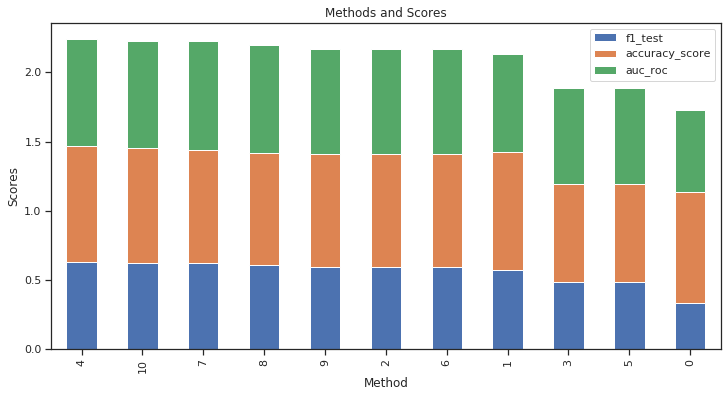

In [40]:
df_results.plot(y=['f1_test','accuracy_score','auc_roc'], kind="bar", stacked=True,figsize=(12,6)).legend(loc='best')
plt.title("Methods and Scores")
plt.xlabel("Method")
plt.ylabel("Scores")

# STEP-8: OVERALL CONCLUSION
- From the above table, the best classifier I found is 
  - RandomForestClassifier	Balanced, depth: 9
  - Its f1_score is .6313, accuracy_score> 0.84, auc_roc: .77.
  
- I will print the auc_roc curve and precision_recall_curve for this classifier.

# ROC curve, Precision-Recall curve for the BEST MODEL
RandomForestClassifier with n_estimators=100,max_depth=9, class_weight='balanced'

In [41]:
model = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=RANDOM_STATE,  class_weight='balanced')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print(probabilities_one_test[:5])

[0.11592979 0.66015128 0.38052144 0.213365   0.10582173]


0.8564835257895342


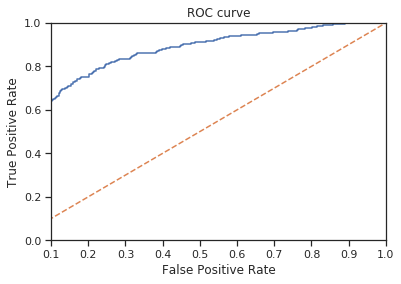

In [42]:
#roc curve
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(auc_roc)

fpr, tpr, thresholds = roc_curve(target_test,probabilities_one_test)

plt.figure()
# < plot the graph >
plt.plot(fpr,tpr)
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.1,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

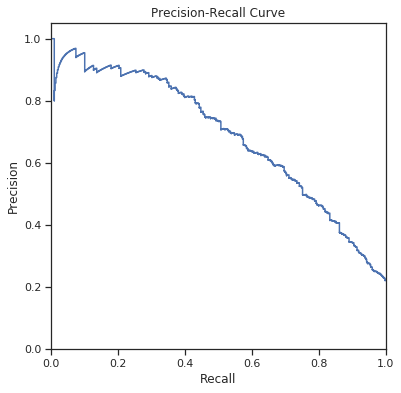

In [43]:
#precision-recall curve
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

# CONCLUSION
- We have imbalanced data with more 0 Churn values than 1 values.
- Using an ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill. ROC graphs are based upon TP rate and FP rate, in which each dimension is a strict columnar ratio, so do not depend on class distributions.
- The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets.
- Our ROC curve, and Precision_recall curve depict that our model is very good. - The ROC curve is much higher than the threshold, and the precision_recall curve is high.



# SANITY CHECK
- To perform sanity check, lets see if the model has better performance than random classification, or classification for just one class (the majority).
- Lets find the larger of the two classes:
- We can measure the **precision** of our model (predictions correct / total correct ) 

### SANITY CHECK ON ENTIRE DATASET

0    0.7963
1    0.2037
Name: Exited, dtype: float64


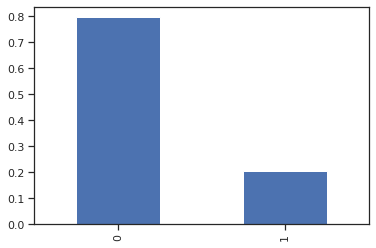

In [44]:
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

- Lets choose the retained clients since that is the larger of the two.
- Our best model products a test accuracy of 81%, lets see if the model outperforms the random classification

In [45]:
target = df['Exited']
features = df.drop('Exited', axis=1)

target_pred_constant = pd.Series([1 for x in range(len(target))], index=target.index)
print('Accuracy for the entire dataset of Churn Customers',accuracy_score(target,target_pred_constant))

Accuracy for the entire dataset of Churn Customers 0.2037


# SANITY CHECK ON TEST DATASET

In [46]:
stay_target = (target_test == 0)
exit_target = (target_test == 1)

print("Number of retained customer clients", stay_target.sum())
print("Number of churn clients", exit_target.sum())
accuracy_check = stay_target.sum() / target_test.shape[0]
print("Accuracy of the Retained customer classifier", accuracy_check )
print("Accuracy of the Churn customer classifier", exit_target.sum() / target_test.shape[0] )

Number of retained customer clients 1582
Number of churn clients 418
Accuracy of the Retained customer classifier 0.791
Accuracy of the Churn customer classifier 0.209


In [47]:
print(classification_report(target_test, predicted_test, target_names=target_names))

              precision    recall  f1-score   support

    Exited 0       0.92      0.86      0.89      1582
    Exited 1       0.57      0.70      0.63       418

    accuracy                           0.82      2000
   macro avg       0.74      0.78      0.76      2000
weighted avg       0.84      0.82      0.83      2000



# CONCLUSION
- The Churn customer base is 20% of the entire test dataset, and 21% of the 
test dataset.
- Our model predicted the retained customers correctly with f1_score of .9, and the churning customers with f1_score of .63. 


# FINAL CONCLUSION
- From the above exercise, the best classifier I found for the Churn.csv dataset:
  - RandomForestClassifier	Balanced, depth: 9
  - Its f1_score is .6313, accuracy_score> 0.84, auc_roc: .77.
- The auc_roc curve and precision_recall_curve for this classifier were also  optimal.

# Project evaluation
We’ve put together the evaluation criteria for the project. Read this carefully before moving on to the task.
- X Here’s what the reviewers will look at when reviewing your project:
- X How did you prepare the data for training? Have you processed all of the feature types?
- X Have you explained the preprocessing steps well enough?
- X How did you investigate the balance of classes?
- X Did you study the model without taking into account the imbalance of classes?
- X What are your findings about the task research?
- X Have you correctly split the data into sets?
- X How have you worked with the imbalance of classes?
- X Did you use at least two techniques for imbalance fixing?
- X Have you performed the model training, validation, and final testing correctly?
- X How high is your F1 score?
- X Did you examine the AUC-ROC values?
- X Have you kept to the project structure and kept the code neat?
